# 🫁 Qwen2.5 Chest X-ray Abnormality Grounding

Locate abnormality areas in chest X-rays using Qwen2.5 and evaluate with mAP.

## 1. Setup & Imports

In [ ]:
import os, json, base64
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import collections
from collections import defaultdict
import numpy as np
%matplotlib inline

def encode_image_to_data_uri(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    return f"data:image/png;base64,{b64}"

DATASET_DIR = "VLM-Seminar25-Dataset/chest_xrays"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANNOT_PATH = os.path.join(DATASET_DIR, "annotations_len_50.json")
RESULTS_DIR = "../results/chest_xrays/grounding"

os.makedirs(RESULTS_DIR, exist_ok=True)

with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)
image_ids = list(annotations.keys())
print(f"Number of images in the dataset: {len(image_ids)}")
print(f"Number of images in the dataset: {len(list(set(image_ids)))}")

load_dotenv(dotenv_path="../config/user.env")
api_key = os.environ.get("NEBIUS_API_KEY")
client = OpenAI(base_url="https://api.studio.nebius.com/v1/", api_key=api_key)

Number of images in the dataset: 50
Number of images in the dataset: 50


In [ ]:
do_new_inference = False

## 2. Model Inference
Only done for unhealthy xrays!

In [ ]:
# For "Other disease", run inference for each bbox/disease in bbox_2d
grounding_results = []
if do_new_inference:
    for img_id in tqdm(image_ids):
        ann = annotations[img_id]
        if ann["status"] == "healthy" or not ann.get("global_disease"):
            continue
        img_path = os.path.join(IMAGES_DIR, img_id + ".png")
        data_uri = encode_image_to_data_uri(img_path)
        for bbox in ann.get("bbox_2d", []):
            if len(bbox) < 5:
                continue
            disease = bbox[4]
            prompt = f"Please locate {disease} and output bounding boxes as floats [x1, y1, x2, y2]. Output nothing else."
            completion = client.chat.completions.create(
                model="Qwen/Qwen2.5-VL-72B-Instruct",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {"type": "image_url", "image_url": {"url": data_uri}},
                        ],
                    }
                ],
            )
            pred = completion.choices[0].message.content.strip()
            #print(f"{img_id} | {disease}: {pred}")
            grounding_results.append({"id": img_id, "disease": disease, "prediction": pred})

  0%|          | 0/50 [00:00<?, ?it/s]

8004676ecf95af8cee446cbcd139a938 | Aortic enlargement: [430,150,480,250]
8004676ecf95af8cee446cbcd139a938 | Cardiomegaly: [300,350,640,750]
8004676ecf95af8cee446cbcd139a938 | Cardiomegaly: [300,350,640,750]
8004676ecf95af8cee446cbcd139a938 | Pulmonary fibrosis: [540,378,769,830]
8004676ecf95af8cee446cbcd139a938 | Pulmonary fibrosis: [540,378,769,830]


  4%|▍         | 2/50 [00:50<20:21, 25.45s/it]

8004676ecf95af8cee446cbcd139a938 | Mass: []
e4e32ce0e061d700c0afda13faa45b1d | Pleural effusion: [580,674,839,826]
e4e32ce0e061d700c0afda13faa45b1d | Pleural effusion: [580,674,839,826]
e4e32ce0e061d700c0afda13faa45b1d | Rib fracture: [705,346,859,500]
e4e32ce0e061d700c0afda13faa45b1d | Rib fracture: [705,346,859,500]
e4e32ce0e061d700c0afda13faa45b1d | Other lesion: [597,168,673,240]
e4e32ce0e061d700c0afda13faa45b1d | Other lesion: [597,168,673,240]


 24%|██▍       | 12/50 [01:30<04:09,  6.56s/it]

e4e32ce0e061d700c0afda13faa45b1d | Infiltration: [560,148,837,809]
5562ea946b0ed8574dd20d05a001d6c4 | Lung Opacity: [560,498,739,720]
5562ea946b0ed8574dd20d05a001d6c4 | Lung Opacity: [560,498,739,720]
5562ea946b0ed8574dd20d05a001d6c4 | Consolidation: [560,498,730,690]
5562ea946b0ed8574dd20d05a001d6c4 | Consolidation: [560,498,730,690]
5562ea946b0ed8574dd20d05a001d6c4 | Mass: []
5562ea946b0ed8574dd20d05a001d6c4 | Mass: []
5562ea946b0ed8574dd20d05a001d6c4 | Other lesion: [439,658,600,743]
5562ea946b0ed8574dd20d05a001d6c4 | Other lesion: [439,658,600,743]
5562ea946b0ed8574dd20d05a001d6c4 | Other lesion: [439,658,600,742]
5562ea946b0ed8574dd20d05a001d6c4 | Other lesion: [439,658,600,742]


 38%|███▊      | 19/50 [01:41<02:11,  4.23s/it]

5562ea946b0ed8574dd20d05a001d6c4 | Calcification: [698,875,864,1036]
07c12d0f562f17579aabc18c11e2ad54 | Aortic enlargement: [530,14,687,290]
07c12d0f562f17579aabc18c11e2ad54 | Aortic enlargement: [530,14,687,290]
07c12d0f562f17579aabc18c11e2ad54 | ILD: [570,134,826,539]
07c12d0f562f17579aabc18c11e2ad54 | ILD: [570,134,826,539]
07c12d0f562f17579aabc18c11e2ad54 | ILD: [560,134,827,914]
07c12d0f562f17579aabc18c11e2ad54 | ILD: [560,134,827,914]
07c12d0f562f17579aabc18c11e2ad54 | Infiltration: [570,123,824,690]
07c12d0f562f17579aabc18c11e2ad54 | Infiltration: [570,123,824,690]
07c12d0f562f17579aabc18c11e2ad54 | Cardiomegaly: [540,138,769,608]
07c12d0f562f17579aabc18c11e2ad54 | Cardiomegaly: [540,138,769,608]


 44%|████▍     | 22/50 [02:00<02:12,  4.72s/it]

07c12d0f562f17579aabc18c11e2ad54 | Pleural thickening: [580,134,769,540]
4a24da485b9550c8df8b19caff945cdc | Cardiomegaly: [490,365,789,850]
4a24da485b9550c8df8b19caff945cdc | Cardiomegaly: [490,365,789,850]
4a24da485b9550c8df8b19caff945cdc | Other lesion: [540,367,643,468]
4a24da485b9550c8df8b19caff945cdc | Other lesion: [540,367,643,468]
4a24da485b9550c8df8b19caff945cdc | Aortic enlargement: [530,367,643,489]
4a24da485b9550c8df8b19caff945cdc | Aortic enlargement: [530,367,643,489]


 48%|████▊     | 24/50 [02:09<02:00,  4.65s/it]

4a24da485b9550c8df8b19caff945cdc | Calcification: [540,367,643,468]
277b457e1e341a9194249937b68cd2c2 | Lung Opacity: [508,439,768,715]
277b457e1e341a9194249937b68cd2c2 | Lung Opacity: [508,439,768,715]


 50%|█████     | 25/50 [02:16<02:03,  4.94s/it]

277b457e1e341a9194249937b68cd2c2 | Pleural effusion: [508,436,798,718]
af4c1f381399cfac17a6e0b983261a4e | Cardiomegaly: [450,287,763,790]
af4c1f381399cfac17a6e0b983261a4e | Cardiomegaly: [450,287,763,790]


 52%|█████▏    | 26/50 [02:20<01:56,  4.86s/it]

af4c1f381399cfac17a6e0b983261a4e | Aortic enlargement: [450,300,670,700]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pulmonary fibrosis: [605,347,980,1035]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pulmonary fibrosis: [605,347,980,1035]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural effusion: [596,704,983,1036]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural effusion: [596,704,983,1036]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural effusion: [597,806,934,1036]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural effusion: [597,806,934,1036]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural thickening: [60,0,987,1035]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural thickening: [60,0,987,1035]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural thickening: [60,0,987,1035]
f5eb3e7e9ee9c4d08377de30251a94e2 | Pleural thickening: [60,0,987,1035]
f5eb3e7e9ee9c4d08377de30251a94e2 | Aortic enlargement: [500,480,796,830]
f5eb3e7e9ee9c4d08377de30251a94e2 | Aortic enlargement: [500,480,796,830]
f5eb3e7e9ee9c4d08377de30251a94e2 | Other lesion: [648,359,720

 54%|█████▍    | 27/50 [02:46<03:11,  8.34s/it]

f5eb3e7e9ee9c4d08377de30251a94e2 | Lung Opacity: [608,347,759,504]
8de556d9cd8d026b8eba03870cc6acba | Pleural effusion: [580,736,874,890]
8de556d9cd8d026b8eba03870cc6acba | Pleural effusion: [580,736,874,890]
8de556d9cd8d026b8eba03870cc6acba | Pulmonary fibrosis: [104,168,930,1035]
8de556d9cd8d026b8eba03870cc6acba | Pulmonary fibrosis: [104,168,930,1035]


 64%|██████▍   | 32/50 [02:52<01:21,  4.50s/it]

8de556d9cd8d026b8eba03870cc6acba | Lung Opacity: [230,285,420,736]
23b0639cd035140def992b0ee7fc34f2 | Cardiomegaly: [408,357,816,849]
23b0639cd035140def992b0ee7fc34f2 | Cardiomegaly: [408,357,816,849]


 68%|██████▊   | 34/50 [02:57<01:03,  3.99s/it]

23b0639cd035140def992b0ee7fc34f2 | Aortic enlargement: [490,350,600,780]
a537060564b5e08c80f46362deb565e8 | Emphysema: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Emphysema: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pleural effusion: [520,564,783,795]
a537060564b5e08c80f46362deb565e8 | Pleural effusion: [520,564,783,795]
a537060564b5e08c80f46362deb565e8 | Pleural thickening: [520,568,749,793]
a537060564b5e08c80f46362deb565e8 | Pleural thickening: [520,568,749,793]
a537060564b5e08c80f46362deb565e8 | Pulmonary fibrosis: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pulmonary fibrosis: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pulmonary fibrosis: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pulmonary fibrosis: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pulmonary fibrosis: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pulmonary fibrosis: [0,0,1036,1036]
a537060564b5e08c80f46362deb565e8 | Pneumothorax: [0,0,1036,1036]
a537060564b5e08c80f46362

 86%|████████▌ | 43/50 [03:35<00:28,  4.14s/it]

a537060564b5e08c80f46362deb565e8 | ILD: [160,305,478,795]
985be77c13eb905ee8e19a45e46ab785 | Pleural effusion: [506,439,938,730]
985be77c13eb905ee8e19a45e46ab785 | Pleural effusion: [506,439,938,730]
985be77c13eb905ee8e19a45e46ab785 | Cardiomegaly: [504,137,869,714]
985be77c13eb905ee8e19a45e46ab785 | Cardiomegaly: [504,137,869,714]
985be77c13eb905ee8e19a45e46ab785 | Other lesion: [968,807,1015,854]
985be77c13eb905ee8e19a45e46ab785 | Other lesion: [968,807,1015,854]
985be77c13eb905ee8e19a45e46ab785 | Other lesion: [968,807,1015,854]
985be77c13eb905ee8e19a45e46ab785 | Other lesion: [968,807,1015,854]


100%|██████████| 50/50 [03:47<00:00,  4.55s/it]

985be77c13eb905ee8e19a45e46ab785 | Other lesion: [968,807,1015,854]


**Interesting prompting note: Without  "If the disease is not present, output '[]'." it outputs coords, otherwise often not, even though all imgs given have the disease!**

## 3. Save Model Predictions

In [ ]:
if do_new_inference:
    with open(os.path.join(RESULTS_DIR, "qwen2.5_grounding_results_per_disease.json"), "w") as f:
        json.dump(grounding_results, f, indent=2)
    print("Saved grounding results per disease.")

Saved grounding results per disease.


Load results

In [45]:
with open(os.path.join(RESULTS_DIR, "qwen2.5_grounding_results_per_disease.json"), "r") as f:
    grounding_results = json.load(f)
print(f"Number of grounding results: {len(grounding_results)}")

Number of grounding results: 64


In [47]:
len(grounding_results), grounding_results[:5]

(64,
 [{'id': '8004676ecf95af8cee446cbcd139a938',
   'disease': 'Aortic enlargement',
   'prediction': '[430,150,480,250]'},
  {'id': '8004676ecf95af8cee446cbcd139a938',
   'disease': 'Cardiomegaly',
   'prediction': '[300,350,640,750]'},
  {'id': '8004676ecf95af8cee446cbcd139a938',
   'disease': 'Pulmonary fibrosis',
   'prediction': '[540,378,769,830]'},
  {'id': '8004676ecf95af8cee446cbcd139a938',
   'disease': 'Mass',
   'prediction': '[]'},
  {'id': 'e4e32ce0e061d700c0afda13faa45b1d',
   'disease': 'Pleural effusion',
   'prediction': '[580,674,839,826]'}])

## 4. Evaluation & Metrics

In [50]:
import collections
sys.path.append("eval_scripts")
from calculate_map import compute_map_supervision, draw_boxes

# Build mapping: (img_id, disease) -> list of GT boxes
gt_boxes_per_img_disease = collections.defaultdict(list)
for img_id, ann in annotations.items():
    if ann["status"] == "healthy" or not ann.get("global_disease"):
        continue
    for bbox in ann.get("bbox_2d", []):
        if len(bbox) < 5:
            continue
        disease = bbox[4]
        gt_boxes_per_img_disease[(img_id, disease)].append(bbox[:4])

# Build mapping: (img_id, disease) -> list of predicted boxes
pred_boxes_per_img_disease = collections.defaultdict(list)
for res in grounding_results:
    img_id = res["id"]
    disease = res["disease"]
    try:
        pred_boxes = json.loads(res["prediction"].replace("'", "\""))
        if isinstance(pred_boxes[0], (int, float)):
            pred_boxes = [pred_boxes]
    except Exception:
        pred_boxes = []
    pred_boxes_per_img_disease[(img_id, disease)].extend(pred_boxes)

# Prepare lists for mAP calculation
all_pred_boxes = []
all_pred_classes = []
all_true_boxes = []
all_true_classes = []
disease_to_class = {}
class_counter = 0

for (img_id, disease), gt_boxes in gt_boxes_per_img_disease.items():
    if disease not in disease_to_class:
        disease_to_class[disease] = class_counter
        class_counter += 1
    class_id = disease_to_class[disease]
    pred_boxes = pred_boxes_per_img_disease.get((img_id, disease), [])
    all_pred_boxes.extend(pred_boxes)
    all_pred_classes.extend([class_id] * len(pred_boxes))
    all_true_boxes.extend(gt_boxes)
    all_true_classes.extend([class_id] * len(gt_boxes))

###  1. Overall mAP

Overall mAP: 0.0050 (mAP@50-95) | 0.0188 (mAP@50) | 0.0000 (mAP@75)


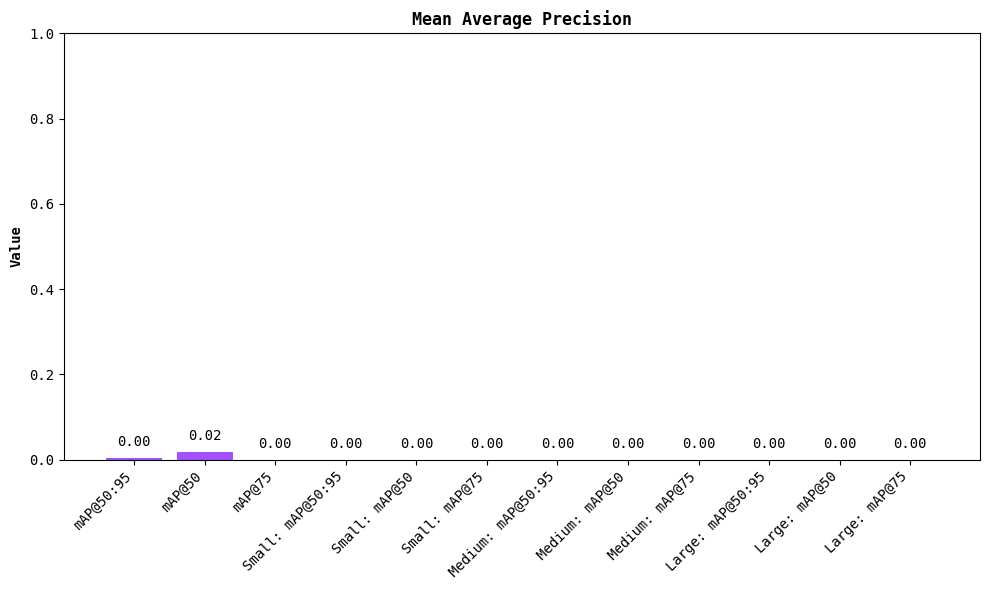

In [61]:
# 1. Overall mAP
overall_result = compute_map_supervision(all_pred_boxes, all_pred_classes, all_true_boxes, all_true_classes)
print(f"Overall mAP: {overall_result.map50_95:.4f} (mAP@50-95) | {overall_result.map50:.4f} (mAP@50) | {overall_result.map75:.4f} (mAP@75)")
overall_result.plot()

###  2. Per-disease mAP

mAP for disease 'Aortic enlargement': 0.0053 (mAP@50-95) | 0.0528 (mAP@50) | 0.0000 (mAP@75)


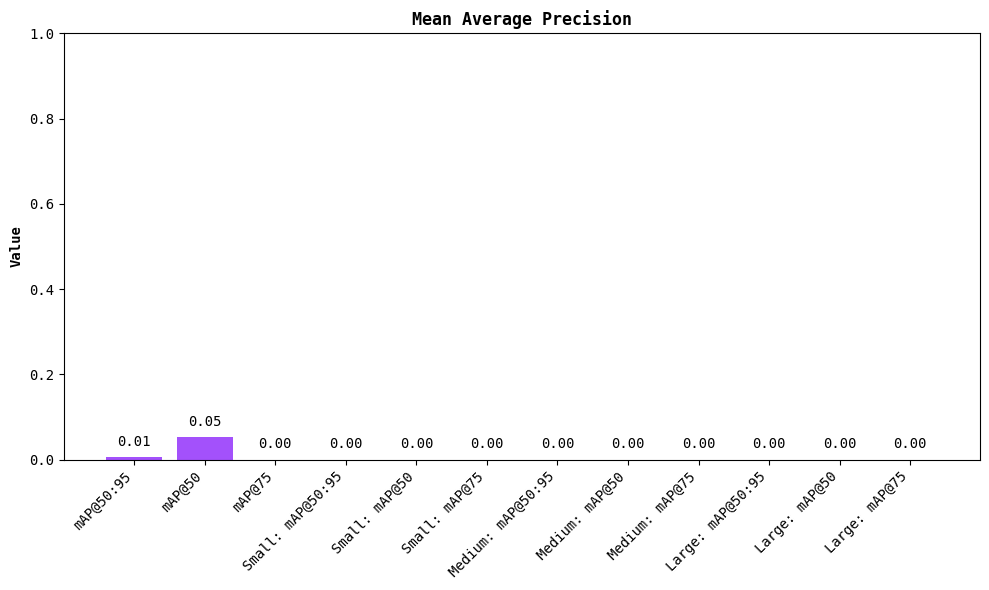

mAP for disease 'Cardiomegaly': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


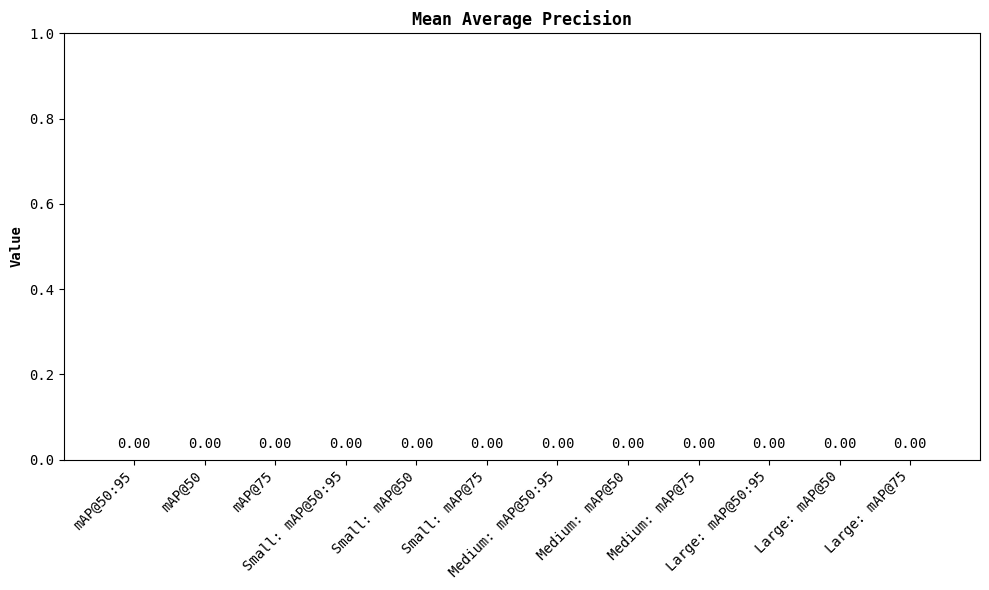

mAP for disease 'Pulmonary fibrosis': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


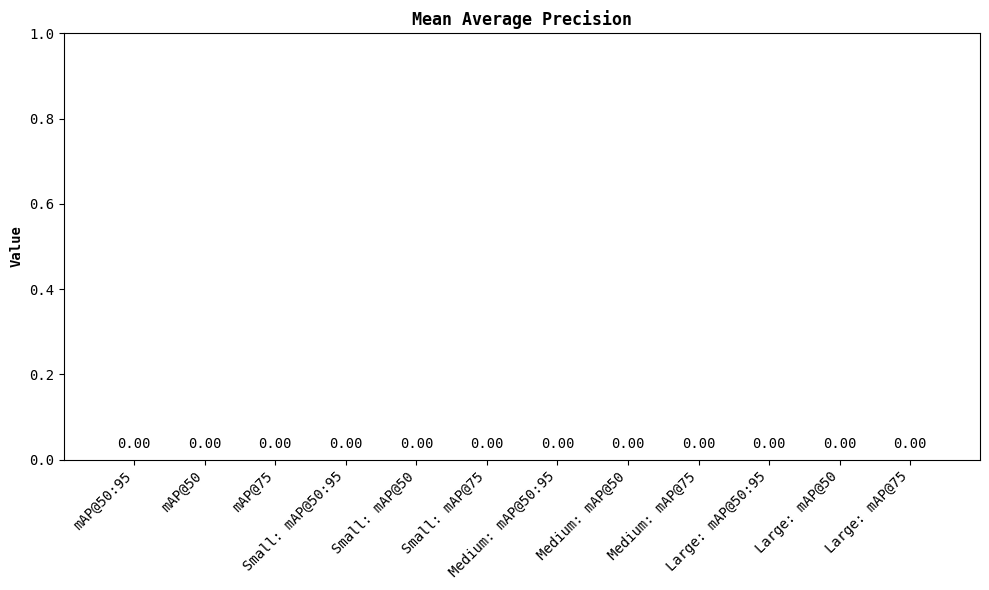

mAP for disease 'Mass': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


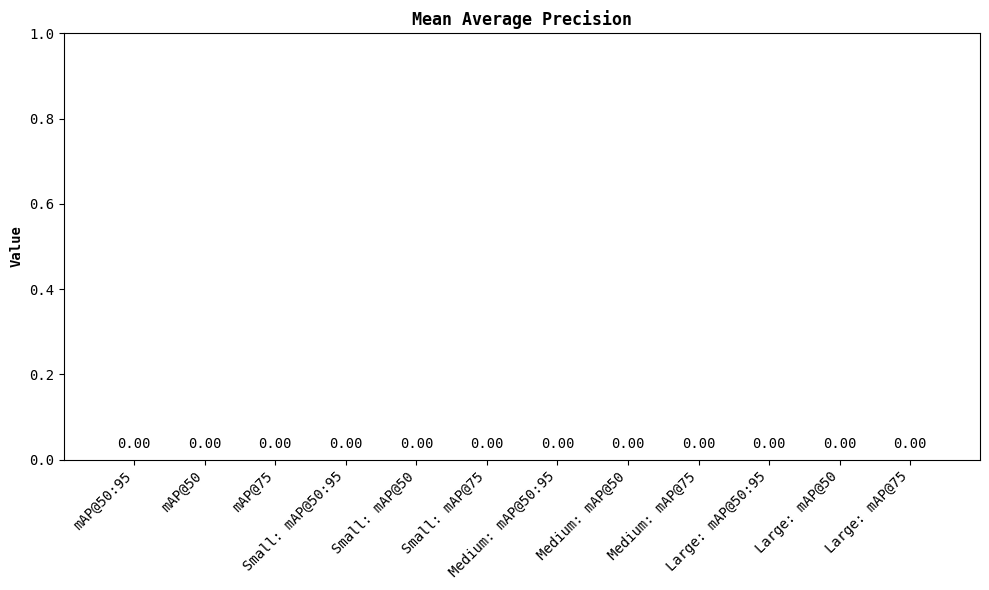

mAP for disease 'Pleural effusion': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


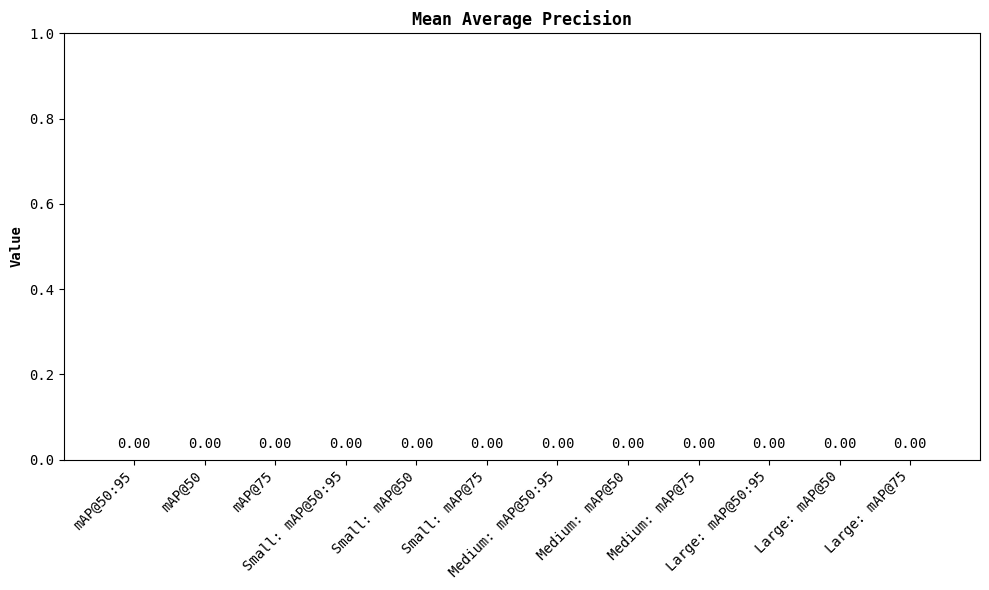

mAP for disease 'Rib fracture': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


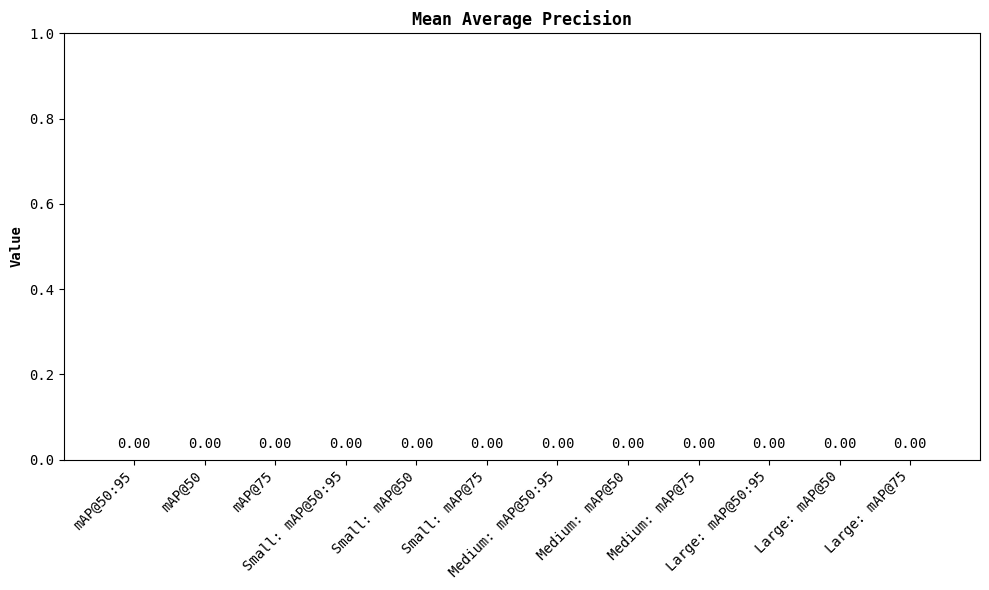

mAP for disease 'Other lesion': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


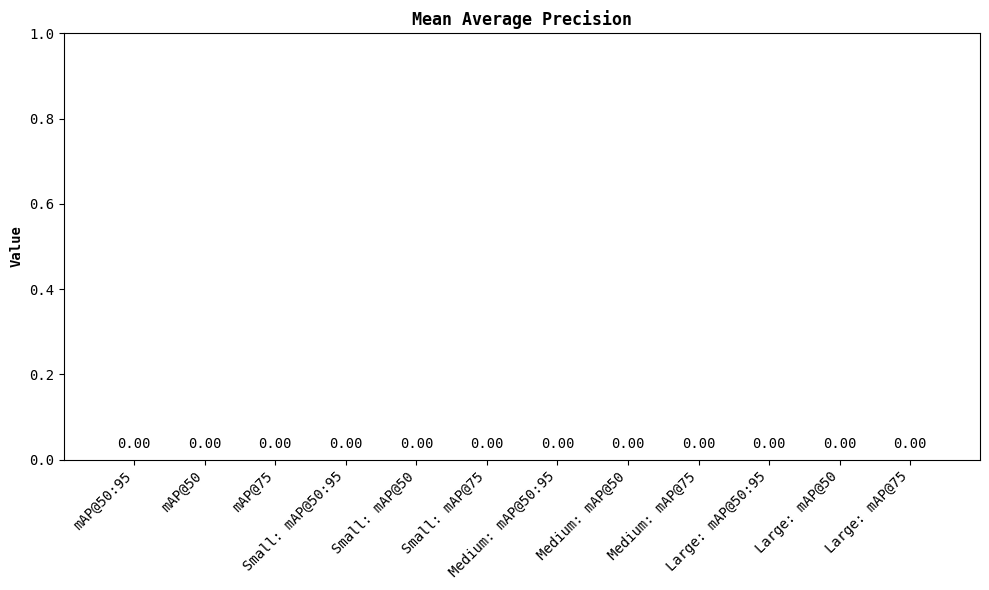

mAP for disease 'Infiltration': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


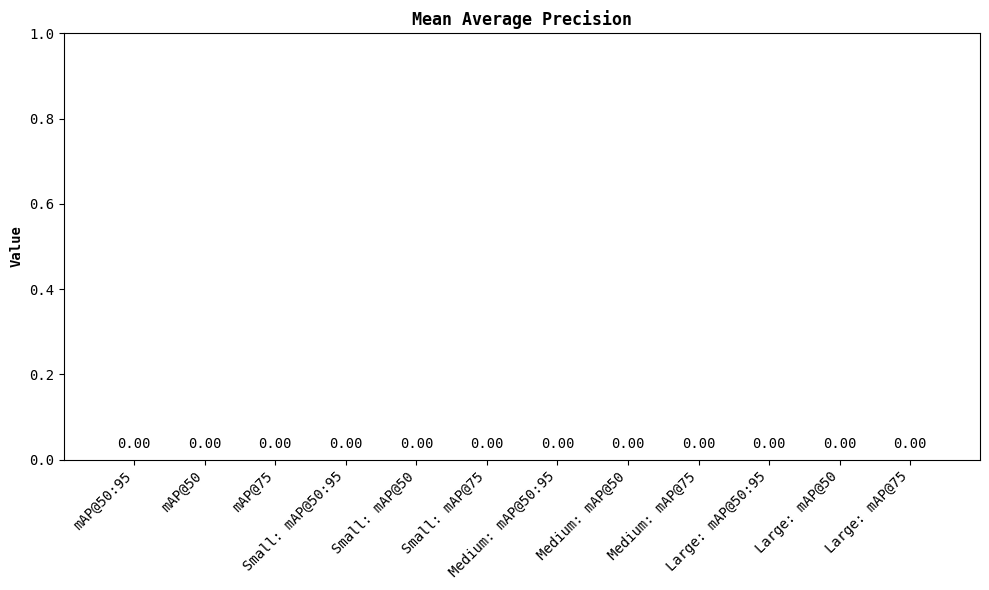

mAP for disease 'Lung Opacity': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


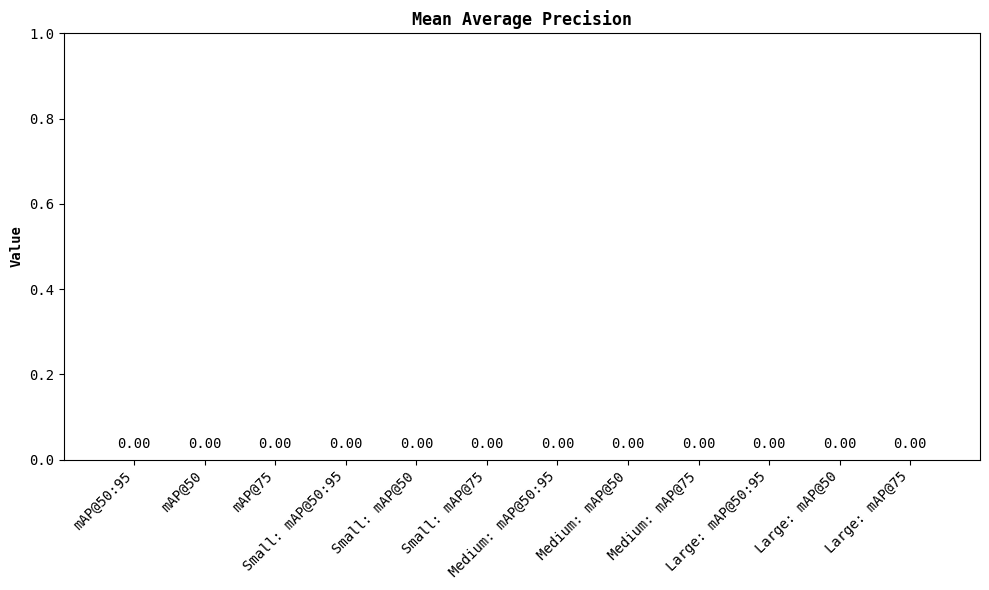

mAP for disease 'Consolidation': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


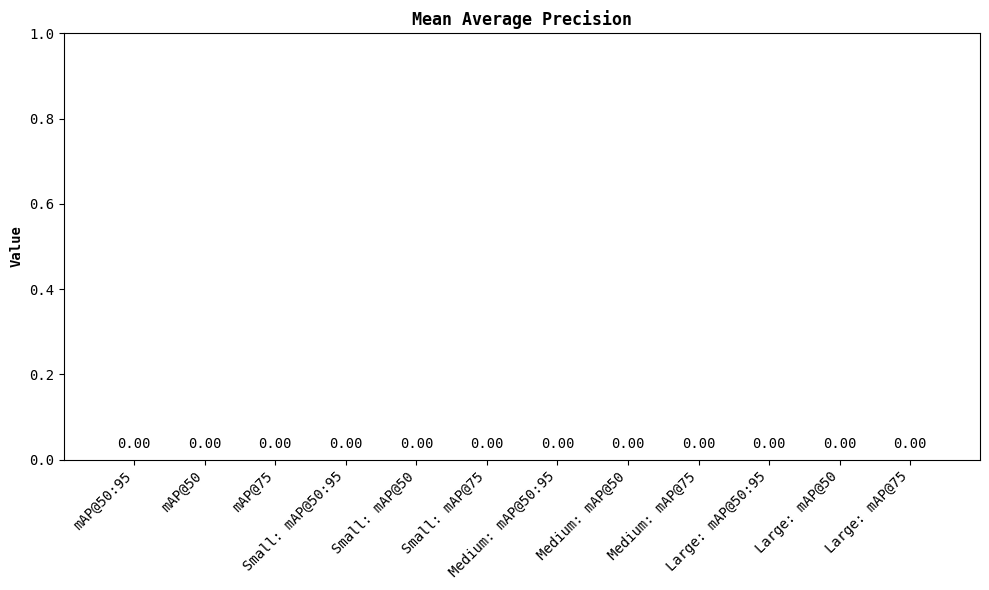

mAP for disease 'Calcification': 0.0743 (mAP@50-95) | 0.2475 (mAP@50) | 0.0000 (mAP@75)


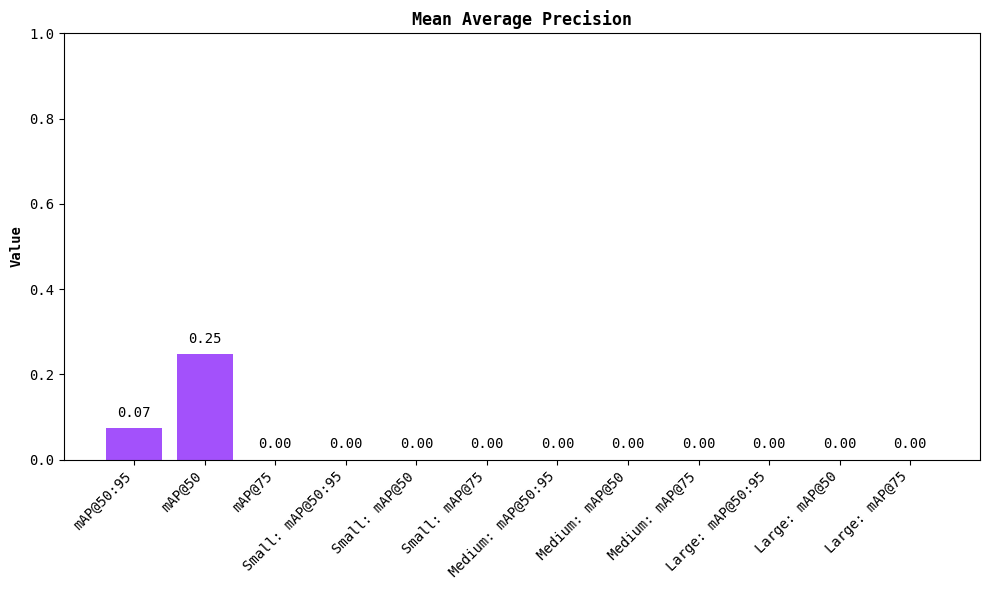

mAP for disease 'ILD': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


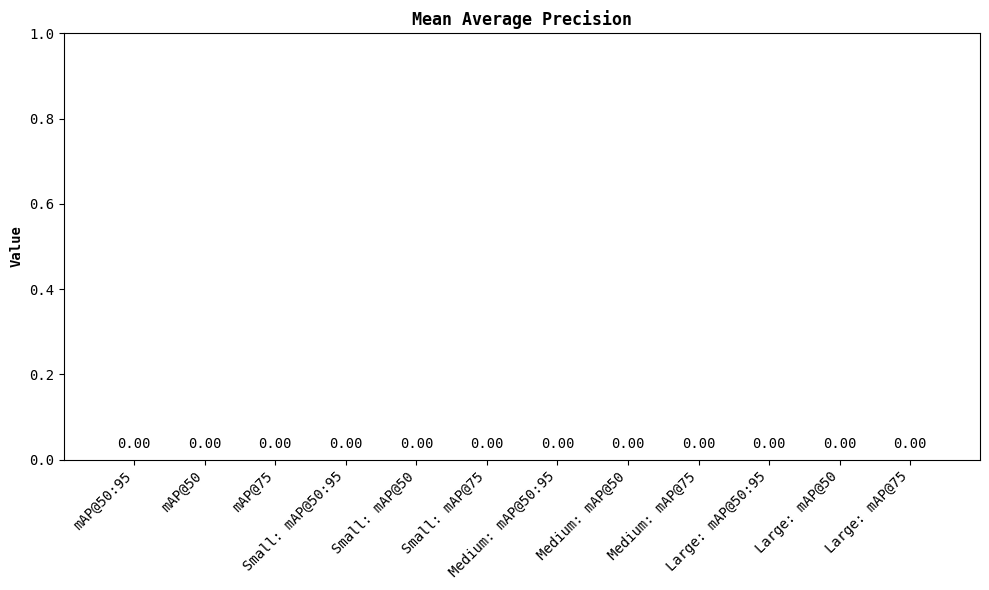

mAP for disease 'Pleural thickening': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


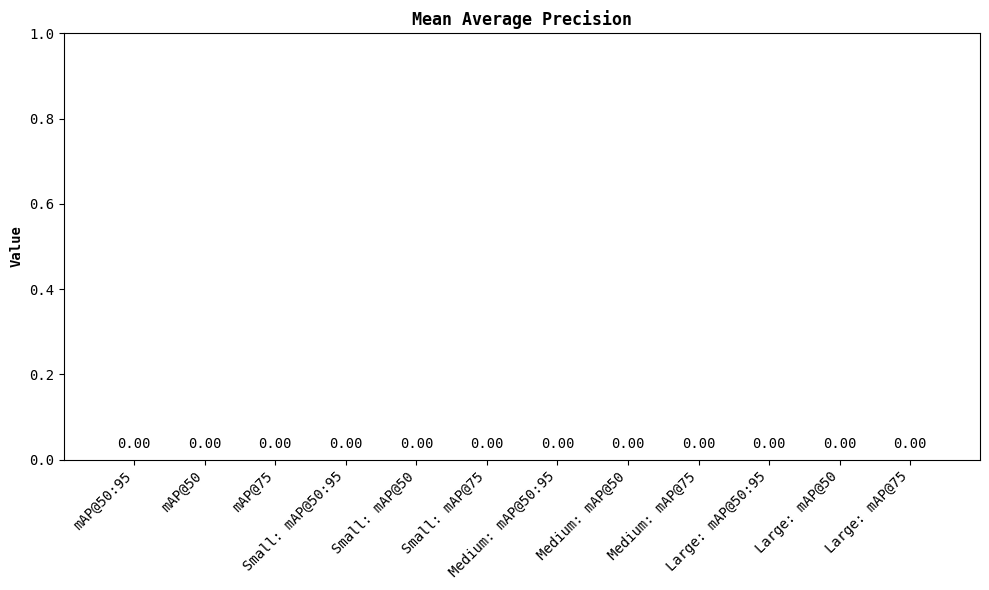

mAP for disease 'Emphysema': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


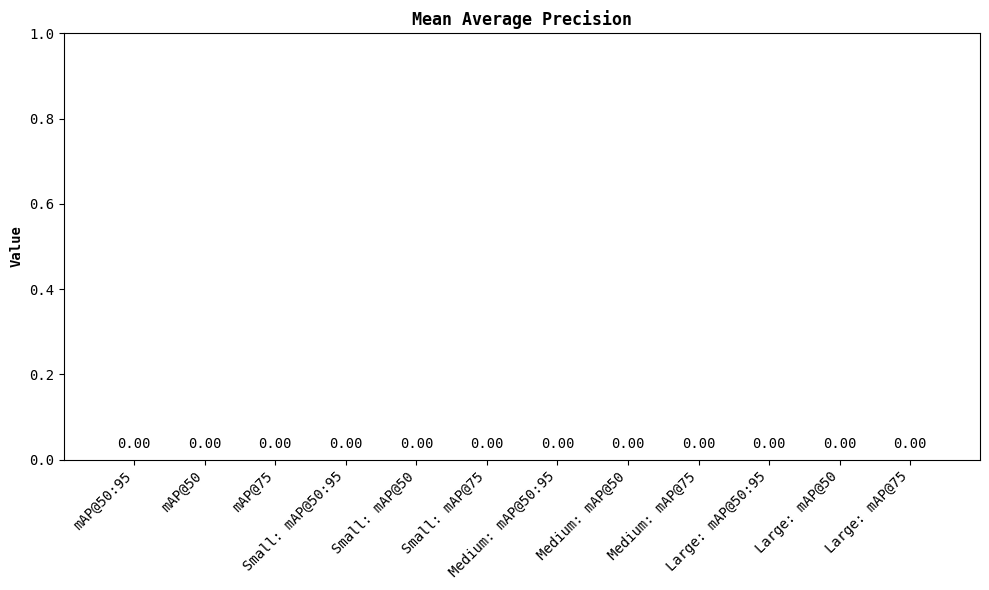

mAP for disease 'Pneumothorax': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


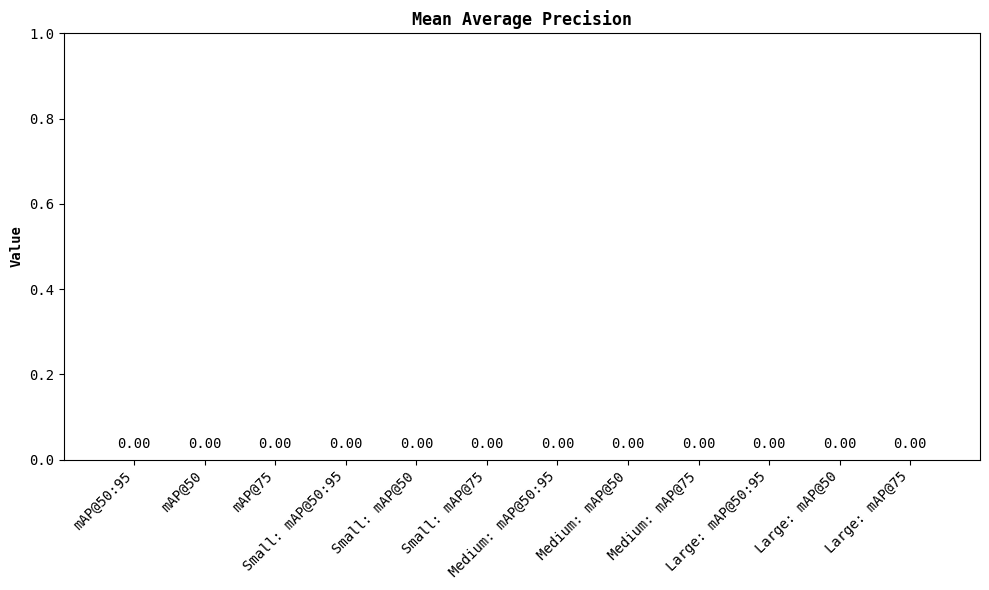

mAP for disease 'Lung cyst': 0.0000 (mAP@50-95) | 0.0000 (mAP@50) | 0.0000 (mAP@75)


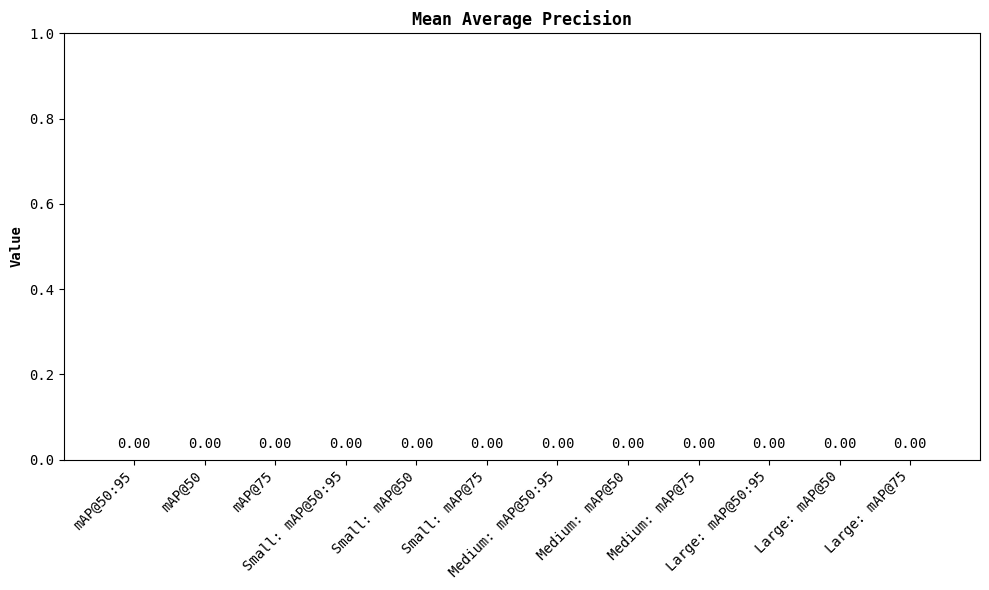

In [63]:
# 2. Per-disease mAP
per_disease_map = {}
for disease, class_id in disease_to_class.items():
    disease_pred_boxes = []
    disease_pred_classes = []
    disease_true_boxes = []
    disease_true_classes = []
    for (img_id, d), gt_boxes in gt_boxes_per_img_disease.items():
        if d != disease:
            continue
        pred_boxes = pred_boxes_per_img_disease.get((img_id, disease), [])
        disease_pred_boxes.extend(pred_boxes)
        disease_pred_classes.extend([class_id] * len(pred_boxes))
        disease_true_boxes.extend(gt_boxes)
        disease_true_classes.extend([class_id] * len(gt_boxes))
    if len(disease_true_boxes) > 0:
        result = compute_map_supervision(disease_pred_boxes, disease_pred_classes, disease_true_boxes, disease_true_classes)
        per_disease_map[disease] = result
        print(f"mAP for disease '{disease}': {result.map50_95:.4f} (mAP@50-95) | {result.map50:.4f} (mAP@50) | {result.map75:.4f} (mAP@75)")
        result.plot()

### 3. Per-image mAP

In [ ]:
# 3. Per-image mAP
per_image_map = {}
for img_id in set([k[0] for k in gt_boxes_per_img_disease.keys()]):
    image_pred_boxes = []
    image_pred_classes = []
    image_true_boxes = []
    image_true_classes = []
    for (i, disease), gt_boxes in gt_boxes_per_img_disease.items():
        if i != img_id:
            continue
        class_id = disease_to_class[disease]
        pred_boxes = pred_boxes_per_img_disease.get((img_id, disease), [])
        image_pred_boxes.extend(pred_boxes)
        image_pred_classes.extend([class_id] * len(pred_boxes))
        image_true_boxes.extend(gt_boxes)
        image_true_classes.extend([class_id] * len(gt_boxes))
    if len(image_true_boxes) > 0:
        result = compute_map_supervision(image_pred_boxes, image_pred_classes, image_true_boxes, image_true_classes)
        per_image_map[img_id] = result
        print(f"mAP for image '{img_id}': {result}")


### 4. Plot per-disease mAP

In [ ]:
# 4. Plot per-disease mAP
import matplotlib.pyplot as plt
if per_disease_map:
    plt.figure(figsize=(10, 4))
    diseases = list(per_disease_map.keys())
    maps = [per_disease_map[d] for d in diseases]
    plt.bar(diseases, maps)
    plt.ylabel("mAP")
    plt.xlabel("Disease")
    plt.title("Per-disease mAP")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 5. Plot per-image mAP (top 10 images by mAP)

In [ ]:
# 5. Plot per-image mAP (top 10 images by mAP)
if per_image_map:
    sorted_items = sorted(per_image_map.items(), key=lambda x: x[1], reverse=True)
    top_imgs = [x[0] for x in sorted_items[:10]]
    top_maps = [x[1] for x in sorted_items[:10]]
    plt.figure(figsize=(10, 4))
    plt.bar(top_imgs, top_maps)
    plt.ylabel("mAP")
    plt.xlabel("Image ID")
    plt.title("Top 10 Images by mAP")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 6. Qualitative: Show example with boxes for a random image

In [ ]:
# 6. Qualitative: Show example with boxes for a random image
import random
example_img_id = random.choice(list(set([k[0] for k in gt_boxes_per_img_disease.keys()])))
example_pred_boxes = []
example_true_boxes = []
for (i, disease), gt_boxes in gt_boxes_per_img_disease.items():
    if i != example_img_id:
        continue
    example_true_boxes.extend(gt_boxes)
    example_pred_boxes.extend(pred_boxes_per_img_disease.get((i, disease), []))
print(f"Qualitative example for image {example_img_id}")
draw_boxes(example_pred_boxes, example_true_boxes, image_size=(1024, 1024))